# Load modules

In [1]:
import pandas as pd
import pyupset as pyu
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from matplotlib_venn import venn2


%matplotlib inline

cas_dict = np.load('plotting_data/cas_abbrev_dict.npy').item()
sample_legend = pd.read_csv('plotting_data/sample_legend.tsv', sep='\t')
all_samples = np.load('plotting_data/all_samples.npy').tolist()
sample_legend.columns = ['sample','pop','superpop']

sample_legend = sample_legend.query('sample in @all_samples')
cas_dict['Cas9-V1'] = 'SpCas9-V1'
cas_dict['Cas9-V2'] = 'SpCas9-V2'
cas_dict['Cas9-V3'] = 'SpCas9-V3'
cas_dict['Cas9'] = 'SpCas9'

def get_canonical(gene_name, gene_annots, outdir=' '):
    """
    Get the canonical (longest) transcript of gene.
    :param gene_name: HUGO gene ID, str.
    :param gene_annots: refseq gene annotations, Pandas dataframe.
    :param outdir: directory to save files outputted by this program, str.
    :return: refseq transcript ID, str.
    """
    canonical_transcript = gene_annots.query('gene_name == @gene_name').name.iloc[0]
    return canonical_transcript


def het(genotype):
    """
    Determine whether a genotype in format A|G is het.
    :param genotype: genotype, str.
    :return: bool, True = het, False = hom.
    """
    hap1, hap2 = str(genotype).split('|')
    return hap1 != hap2


def load_gene_annots(annots_path):
    """
    Load gene annotation data (transcript data).
    :param annots_path: str, filepath for gene_annots_wsize (Part of ExcisionFinder package).
    :return: Refseq gene annotations file.
    """
    gene_annots = pd.read_csv(annots_path, sep='\t', header=0, names=['name', 'chrom', 'txStart', 'txEnd',
                                                                      'cdsStart', 'cdsEnd', 'exonCount',
                                                                      'exonStarts', 'exonEnds', 'gene_name',
                                                                      'size']).sort_values(by='size', ascending=False)
    return gene_annots

gene_annots = load_gene_annots('plotting_data/gene_annots_wsize')

In [7]:
transcript = get_canonical('RBM20', gene_annots)
gene_annots.query('name == @transcript')

,name,chrom,txStart,txEnd,cdsStart,cdsEnd,exonCount,exonStarts,exonEnds,gene_name,size
35664,NM_001134363,chr10,112404154,112599229,112404212,112595736,14,"112404154,112540558,112543123,112544098,112544...","112404403,112541642,112543185,112544190,112544...",RBM20,195075


In [3]:
112404212 - 2000

112402212

In [4]:
112595736 + 2000

112597736

In [9]:
112599229 + 2000

112601229

In [5]:
pd.read_hdf('/pollard/data/1kg/excisionFinderData/targ_dfs/chr10_targ.hdf5', where='pos <= 112404212 and pos >= 112402212')

/pollard/home/kathleen/tools/anaconda3/lib/python3.6/site-packages/tables/leaf.py:396: PerformanceWarning: The Leaf ``/all/_i_table/alt/sorted`` is exceeding the maximum recommended rowsize (104857600 bytes);
be ready to see PyTables asking for *lots* of memory and possibly slow
I/O.  You may want to reduce the rowsize by trimming the value of
dimensions that are orthogonal (and preferably close) to the *main*
dimension of this leave.  Alternatively, in case you have specified a
very small/large chunksize, you may want to increase/decrease it.
  PerformanceWarning)


,chrom,pos,ref,alt,id,af,makes_cpf1,makes_SpCas9,makes_SpCas9_VRER,makes_SpCas9_EQR,...,var_near_SpCas9_EQR,var_near_SpCas9_VQR_1,var_near_SpCas9_VQR_2,var_near_StCas9,var_near_StCas9_2,var_near_SaCas9,var_near_SaCas9_KKH,var_near_nmCas9,var_near_cjCas9,var_near_cpf1
3268041,10,112402386,T,A,rs531192196,0.000200,0,0,0,0,...,1,1,1,0,0,0,1,0,1,1
3268042,10,112402425,G,A,rs549328600,0.002596,0,0,0,1,...,1,1,1,0,0,0,1,1,0,1
3268043,10,112402427,GTT,GT,rs554241405,0.735423,1,0,0,0,...,1,1,1,0,0,0,1,1,0,1
3268044,10,112402447,G,T,rs571029086,0.000200,0,0,0,0,...,1,1,1,1,1,1,0,0,1,1
3268045,10,112402492,G,C,rs10885003,0.225439,0,0,0,0,...,0,1,0,1,0,0,1,0,1,0
3268046,10,112402514,T,C,rs186476705,0.000200,0,0,0,0,...,1,1,1,0,0,0,0,0,1,0
3268047,10,112402563,TTTTG,T,rs201520135,0.016574,0,0,0,0,...,0,1,0,0,0,1,1,0,1,1
3268048,10,112402565,T,C,rs371291386,0.001997,0,0,0,0,...,0,1,0,0,0,1,1,0,1,1
3268049,10,112402591,G,A,rs190763441,0.000200,0,0,0,0,...,1,1,1,0,0,0,1,0,1,1
3268050,10,112402765,G,C,rs570102181,0.000200,0,0,0,1,...,1,1,1,1,1,1,1,0,1,1


# Figure 1b: het variants generate allele-specific CRISPR sites

Most heterozygous variants generate an allele-specific CRISPR site for at least one variety of Cas. The proportion of variants that generate allele-specific CRISPR sites is less when only considering variants that are in a PAM. 

In [20]:
all_chr_df_list = []

for chrom in list(range(2,23)):
    chrom = str(chrom)
    chr_hdf = pd.read_hdf(f'/pollard/data/1kg/excisionFinderData/targ_dfs/chr{chrom}_targ.hdf5', 'all').sample(1000)
    chr_hdf.head()
    all_chr_df_list.append(chr_hdf)

all_chr_df = pd.concat(all_chr_df_list)

all_chr_df = all_chr_df.drop(columns=['chrom','pos','ref','alt','id','af']).applymap(bool)
all_chr_df['id'] = all_chr_df.index

in_pam_dict = {}
near_pam_dict = {}

cas_list = ['cpf1','SpCas9','SpCas9_VRER','SpCas9_EQR','StCas9',
           'StCas9_2','SaCas9','SaCas9_KKH','nmCas9','cjCas9']
for cas in cas_list:
    in_pam_dict[cas] = all_chr_df.query(f'makes_{cas} or breaks_{cas}')['id'].tolist()
    near_pam_dict[cas] = all_chr_df.query(f'var_near_{cas}')['id'].tolist()
    
in_pam_dict['SpCas9_VQR'] = all_chr_df.query('makes_SpCas9_VQR_1 or breaks_SpCas9_VQR_1 \
                                              or makes_SpCas9_VQR_2 or breaks_SpCas9_VQR_2')['id'].tolist()
near_pam_dict['SpCas9_VQR'] = all_chr_df.query('var_near_SpCas9_VQR_1 \
                                              or var_near_SpCas9_VQR_2')['id'].tolist()

total_vars = all_chr_df.shape[0]

labels = []
cases = []
perc_vars = []

inplot = []
nearplot = []
bothplot = []
cases2 = []
totals = []

for cas in cas_list + ['SpCas9_VQR']:
    near_pam = set(near_pam_dict[cas])
    in_pam = set(in_pam_dict[cas])
    both = near_pam.intersection(in_pam)
    nearpam = list(near_pam - both)
    inpam = list(in_pam - both)
#     total_vars = len(both) + len(nearpam) + len(inpam)
    near_out = len(nearpam) / total_vars
    in_out = len(inpam) / total_vars
    both_out = len(both) / total_vars
    perc_vars.extend([near_out, in_out, both_out])
    labels.extend(['near','in','both'])
    cases.extend([cas] * 3)
    inplot.extend([in_out])
    nearplot.extend([near_out])
    bothplot.extend([both_out])
    cases2.extend([cas])
    total = in_out + near_out + both_out
    totals.append(total)
    

plotdf = pd.DataFrame({'near PAM':nearplot, 'in PAM':inplot,'both':bothplot,'cas':cases2, 'total':totals}).replace(to_replace=cas_dict).sort_values(by='total')

plotdf.index = plotdf.cas

plotdf = plotdf[['both','in PAM','near PAM']]

plotdf.plot.bar(stacked='True', color=sns.color_palette('Dark2'), figsize=(12,4))
plt.legend(bbox_to_anchor=(1.0, 0.5))
plt.xticks(rotation=45)
plt.ylabel('Proportion of Variants')
plt.xlabel('Cas Variety')
# plt.savefig('figures/allelespecsites_by_variants.pdf', dpi=300, bbox_inches='tight')

# Figure 1d: dual > single
In an individual genome (WTC), a dual-cutting strategy allows us to target many more genes compared to a single-cut strategy. This figure considers only protein-coding genes with at least 2 heterozygous variants in the individual genome of WTC. This estimate for dual-cutting targetability is conservative as it only considers genic variants, and many more genes are targetable if we expand the range outside the gene.

In [16]:
overall = pd.read_csv('../wtc_ef/wtc_ef_plotting_data/wtc_single_dual_targeting.tsv', sep='\t')

overall['size_kb'] = overall['size'] / 1000

# Subset sizes
s = (
    overall.query('targ_type == "dual"').shape[0],  # Ab
    overall.query('targ_type == "single"').shape[0],  # aB
    overall.query('targ_type == "both"').shape[0])
v = venn2(subsets=s, set_labels=['Dual Only','Single Only'])
colors = list(sns.color_palette("Dark2", n_colors=4))
v.get_patch_by_id('10').set_color(colors[0])
v.get_patch_by_id('01').set_color(colors[2])
v.get_patch_by_id('11').set_color(colors[1])
# v.get_patch_by_id('001').set_color(colors[3])
# v.get_patch_by_id('001').set_color(colors[3])
# v.get_patch_by_id('101').set_color(colors[4])
# v.get_patch_by_id('011').set_color(colors[5])
# v.get_patch_by_id('111').set_color(colors[6])

# v.get_label_by_id('10').set_text('Dual Cuts')
# v.get_label_by_id('01').set_text('Single Cuts')
# v.get_label_by_id('11').set_text('Both')
plt.savefig('figures/wtc_single_vs_dual_venn.pdf', dpi=300)

# Figure 1e: different # targ genes per ind
Considering all varieties of Cas greatly expands the proportion of targetable genes per individual in the 1000 Genomes cohort. However, the classic SpCas9 ranks among the top Cas varieties in terms of gene targetability.

all
SpCas9_VQR_1
SpCas9_VQR_2
SpCas9
SpCas9_VRER
SpCas9_EQR
StCas9
StCas9_2
SaCas9
SaCas9_KKH
nmCas9
cjCas9
cpf1


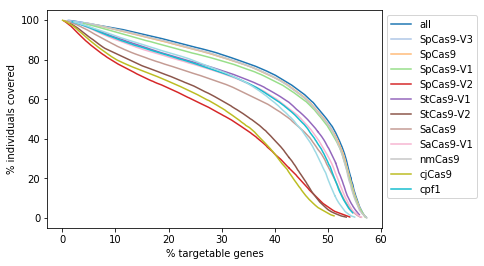

In [4]:
overall_df = pd.read_csv('plotting_data/gene_targ_plotting.tsv', sep='\t')

cas_dict = np.load('plotting_data/cas_abbrev_dict.npy').item()

g = plt.figure()
CAS_LIST = ['all', 'SpCas9_VQR_1',
            'SpCas9_VQR_2', 'SpCas9', 'SpCas9_VRER', 'SpCas9_EQR', 'StCas9', 'StCas9_2',
            'SaCas9', 'SaCas9_KKH', 'nmCas9',
            'cjCas9', 'cpf1']

colors = iter(cm.tab20(np.linspace(0,1,len(CAS_LIST))))
for cas in CAS_LIST:
    print(cas)
    if cas == 'SpCas9_VQR_1' or cas == 'SpCas9_VQR_2':
#         cas_sample_df = overall_df.sample(1000).loc[(overall_df['cas']=='SpCas9_VQR_1') | (overall_df['cas']=='SpCas9_VQR_2')].sort_values('%_genes')
        cas_sample_df = overall_df.sample(1000).loc[overall_df['cas']=='SpCas9_VQR_1'].sort_values('%_genes')
        plt.plot(cas_sample_df['%_genes'],cas_sample_df['%_ppl'],color=next(colors))
    else:
        cas_sample_df = overall_df.sample(1000).loc[overall_df['cas']==cas].sort_values('%_genes')
        plt.plot(cas_sample_df['%_genes'],cas_sample_df['%_ppl'],color=next(colors))
plt.xlabel("% targetable genes")
plt.ylabel("% individuals covered")
plt.legend(['all','SpCas9-V3']+list(cas_dict[cas] for cas in CAS_LIST[3:]), bbox_to_anchor=(1,1))
# g.savefig('figures/gene_targ_nochr1.pdf', dpi=300, bbox_inches='tight')

# Figure 2a: targ around vs just in gene

The gene RHO, which causes dominant negative retinitis pigmentosa is relatively small, and therefore can be difficult to target. A useful capability of ExcisionFinder is its ability to analyze a user-specified window around a gene. For RHO, we chose a 5 kb window in order to maximize the genomic region in which to find heterozygous variants, but without disrupting genes that were present in the larger 10 kb window. Figure a demonstrates that, indeed, analyzing the region around RHO enables us to target more individuals from each 1000 Genomes population. 

In [5]:
rho_5kb = pd.read_hdf('plotting_data/RHO_5kb/chr3_out.hdf5','RHO').merge(sample_legend, how='left')
rho_gene_only = pd.read_hdf('/pollard/data/1kg/ef/gene_targ_outputs/chr3/chr3_out.hdf5', 'RHO').merge(sample_legend, how='left')

# rho_5kb.query('targ_all').shape[0]/2504.0

rho_5kb_prop = {}
for pop in sample_legend['pop'].drop_duplicates().tolist():
    samples = sample_legend.query('pop == @pop')['sample'].tolist()
    rho_5kb_prop[pop] = rho_5kb.query('sample in @samples and targ_all').shape[0]/sample_legend.query('pop == @pop').shape[0]

rho_gene_only_prop = {}
for pop in sample_legend['pop'].drop_duplicates().tolist():
    samples = sample_legend.query('pop == @pop')['sample'].tolist()
    rho_gene_only_prop[pop] = rho_gene_only.query('sample in @samples and targ_all').shape[0]/sample_legend.query('pop == @pop').shape[0]

rho_5kb_propdf = pd.DataFrame.from_dict(rho_5kb_prop, orient='index')
rho_5kb_propdf.columns=['prop_targ']
rho_5kb_propdf['pop'] = rho_5kb_propdf.index
rho_5kb_propdf = rho_5kb_propdf.merge(sample_legend[['pop','superpop']].drop_duplicates())
rho_5kb_propdf['id'] = '5kb'

rho_gene_only_propdf = pd.DataFrame.from_dict(rho_gene_only_prop, orient='index')
rho_gene_only_propdf.columns=['prop_targ']
rho_gene_only_propdf['pop'] = rho_gene_only_propdf.index
rho_gene_only_propdf = rho_gene_only_propdf.merge(sample_legend[['pop','superpop']].drop_duplicates())
rho_gene_only_propdf['id'] = 'gene_only'

plot_df = pd.concat([rho_5kb_propdf, rho_gene_only_propdf]).sort_values(by='prop_targ')
plot_df['perc_targ'] = plot_df['prop_targ'] * 100.0

colors = list(sns.color_palette("Dark2", n_colors=4))
# fig, ax = plt.subplots(figsize=(24, 6))
p = sns.FacetGrid(plot_df,col='superpop', sharex=False, gridspec_kws={"width_ratios": [5, 4, 5, 5, 7]})
p.map(sns.barplot, 'pop', 'perc_targ','id',palette={'5kb':colors[2],'gene_only':colors[0]})
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
# plt.setp(p.get_xticklabels(), rotation=45)
plt.savefig('figures/rho_5kbwindow_vs_none.pdf', dpi=300, bbox_inches='tight')

# Figure 2c: shared pairs RHO

Numerous pairs of allele-specific CRISPR sites are shared by at least 10 percent of the overall 1000 Genomes cohort, as demonstrated here. Based on these results, we were motivated to determine whether we could optimize combinations of sgRNA pairs to cover the maximum possible number of people. 

Prop targetable overall is 0.7312300319488818
Prop covered overall by 5 optimal sgRNAs is 0.5766773162939297
Prop covered of targetable by 5 optimal sgRNAs is 0.7886400873839432


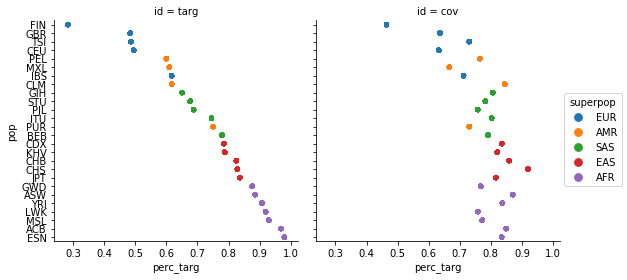

In [6]:
colors = list(sns.color_palette("Dark2", n_colors=5))

targ_dat = pd.read_hdf('plotting_data/RHO_5kb/chr3_out.hdf5','RHO').merge(sample_legend, how='left')

targ_pops = targ_dat.merge(sample_legend, how='left')

plot_dict = {}

for pop in list(set(sample_legend['pop'].tolist())):
    plot_dict[pop] = targ_pops.query('pop == @pop and targ_all').shape[0]/sample_legend.query('pop == @pop').shape[0]

plot_df = pd.DataFrame.from_dict(plot_dict, orient='index')
plot_df['pop'] = plot_df.index
plot_df.columns=['perc_targ','pop']
plot_df = plot_df.merge(sample_legend)
plot_df = plot_df.sort_values(by='perc_targ')

ppl_cov_five = pd.read_csv('plotting_data/RHO_5kb_setcover__ppl_covered.txt', header=None,
                          names=['sample'])

ppl_cov_five = ppl_cov_five.merge(sample_legend)

plot_dict_cov = {}

for pop in list(set(plot_df['pop'].tolist())):
#     print(pop)
    plot_dict_cov[pop] = ppl_cov_five.query('pop == @pop').shape[0]/targ_dat.query('pop == @pop and targ_all').shape[0]

plot_df_final = pd.DataFrame.from_dict(plot_dict_cov, orient='index')
plot_df_final['pop'] = plot_df_final.index
plot_df_final.columns=['perc_targ','pop']
plot_df_final = plot_df_final.merge(sample_legend)

plot_df['id'] = 'targ'
plot_df_final['id'] = 'cov'

dual = pd.concat([plot_df, plot_df_final])
dual.to_csv('plotting_data/rho_5kb_plot_df.tsv', sep='\t', index=False)

p = sns.factorplot(x='perc_targ', y='pop', hue='superpop',col='id', data=dual, kind='strip')
print('Prop targetable overall is ' + str(targ_dat.query('targ_all').shape[0]/len(all_samples)))
print('Prop covered overall by 5 optimal sgRNAs is ' +str(ppl_cov_five.shape[0]/len(all_samples)))
print('Prop covered of targetable by 5 optimal sgRNAs is ' +str(ppl_cov_five.shape[0]/targ_dat.query('targ_all').shape[0]))

# p.savefig('figures/rho5kb_targ_cov_five_common.pdf', dpi=300)

In [9]:
# ppl_cov_five.shape[0]/rho_pops.query('targ_all').shape[0]

ppl_cov_five.shape[0]/len(all_samples)

0.5766773162939297

# Figure 2d: Different populations have different #s of targ genes

Upon seeing the disparity in targetable population proportions for RHO, we were intrigued to see the overall differences in targetable genes by population. Here we get a view of this, following along previous results of differing heterozygosity in different populations. 

In [6]:
genes_eval = len(np.load('../ef_data/genes_evaluated.npy').tolist())
# genes_eval

dat = pd.read_csv('../ef_data/targ_genes_per_person.tsv', sep='\t')
dat.columns = ['sample','n_genes_targ']
dat['%_genes_targ'] = 100.0*(dat['n_genes_targ'] / genes_eval)
dat = dat.merge(sample_legend)

np.mean(dat['%_genes_targ'])

agg = dat.groupby('pop').mean()
agg['pop'] = agg.index
agg = agg.merge(sample_legend[['pop','superpop']]).drop_duplicates().reset_index(drop=True).sort_values(by='superpop')
# agg

# sns.violinplot(x='superpop', y='n_genes_targ', 
#                hue='superpop', data=agg, palette='tab20', inner=None)
p = sns.swarmplot(x='superpop', y='%_genes_targ', hue='pop',
               data=agg, palette='tab20', size=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0, ncol=2)
plt.savefig('figures/targ_genes_per_person.pdf', dpi=300,
           bbox_inches='tight')

13248

# Supplementary Figure 1: vars to allele-specific sites by cas
Some Cas nucleases make more allele-specific CRISPR sites than others. 

/pollard/home/kathleen/tools/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


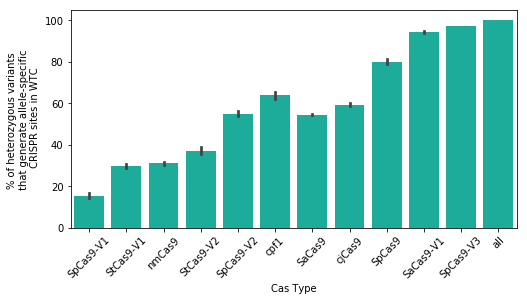

In [4]:
cas_dict['Cas9-V1'] = 'SpCas9-V1'
cas_dict['Cas9-V2'] = 'SpCas9-V2'
cas_dict['Cas9-V3'] = 'SpCas9-V3'
cas_dict['Cas9'] = 'SpCas9'
cas_dict['StCas9-2'] = 'StCas9-V2'

wtc_var_plot_df = pd.read_csv('../wtc_ef/wtc_ef_plotting_data/wtc_var_plot_df.tsv', sep='\t')
# type(wtc_var_plot_df)

wtc_var_plot_df.sort_values(by='prop_targ_vars', inplace=True)
wtc_var_plot_df.replace(to_replace=cas_dict, inplace=True)
wtc_var_plot_df['%_targ_vars'] = wtc_var_plot_df['prop_targ_vars'] * 100.0
type(wtc_var_plot_df)
wtc_var_plot_df.head()

fig, ax = plt.subplots(figsize=(8, 4))
p = sns.barplot(x='cas', y='%_targ_vars', data=wtc_var_plot_df,
                color='xkcd:turquoise')
p.set(xlabel='Cas Type', ylabel='% of heterozygous variants \n that generate allele-specific \n CRISPR sites in WTC')
plt.setp(p.get_xticklabels(), rotation=45)
fig.savefig('figures/wtc_variant_targ.pdf', dpi=300, bbox_inches='tight')

# Supplementary Figure 2: PAM motifs and size

PAM motif occurrences in hg19 are correlated with their size. 

In [14]:
cas_dict_rev = {'SaCas9': 'SaCas9',
 'SaCas9-V1': 'SaCas9_KKH',
 'SpCas9': 'SpCas9',
 'SpCas9-V1': 'SpCas9_VRER',
 'SpCas9-V2': 'SpCas9_EQR',
 'SpCas9-V3': 'SpCas9_VQR_2',
 'StCas9-V1': 'StCas9',
 'StCas9-V2': 'StCas9_2',
 'cjCas9': 'cjCas9',
 'cpf1': 'cpf1',
 'nmCas9': 'nmCas9'}

In [22]:
pam_sizes = {'SpCas9':2, 'SpCas9-V1':3, 'SpCas9-V2':3, 'SpCas9-V3':2.5, 'SaCas9':4, 'SaCas9-V1':2,
            'nmCas9':4, 'cpf1':3, 'StCas9-V1':4, 'StCas9-V2':4, 'cjCas9':3}

cas_list = pam_sizes.keys()

pams_in_genome = {}
chroms = list(range(1,23))

for cas in cas_list:
    if cas == 'Cas9-V3':
        orig_cas = cas
        n_in_genome = 0
        for chrom in chroms:
            for_pams = np.load(f'../preprocessing/hg19_chr_pams/chr{chrom}_SpCas9_VQR_1_pam_sites_for.npy').tolist()
            for_pams.extend(np.load(f'../preprocessing/hg19_chr_pams/chr{chrom}_SpCas9_VQR_2_pam_sites_for.npy').tolist())
            rev_pams = np.load(f'../preprocessing/hg19_chr_pams/chr{chrom}_SpCas9_VQR_1_pam_sites_rev.npy').tolist()
            rev_pams.extend(np.load(f'../preprocessing/hg19_chr_pams/chr{chrom}_SpCas9_VQR_2_pam_sites_rev.npy').tolist())            
            n_in_genome += len(for_pams) + len(rev_pams)
        pams_in_genome[orig_cas] = n_in_genome
        print(cas, n_in_genome)
    else:
        orig_cas = cas
        cas = cas_dict_rev[cas]
        n_in_genome = 0
        for chrom in chroms:
            for_pams = np.load(f'../preprocessing/hg19_chr_pams/chr{chrom}_{cas}_pam_sites_for.npy').tolist()
            rev_pams = np.load(f'../preprocessing/hg19_chr_pams/chr{chrom}_{cas}_pam_sites_rev.npy').tolist()
            n_in_genome += len(for_pams) + len(rev_pams)
        print(orig_cas, n_in_genome)
        pams_in_genome[orig_cas] = n_in_genome

SpCas9 281005914
SpCas9-V1 12967542
SpCas9-V2 90763866
SpCas9-V3 255675527
SaCas9 98743451
SaCas9-V1 353751593
nmCas9 32771942
cpf1 205859166
StCas9-V1 41959549
StCas9-V2 68606312
cjCas9 108040050


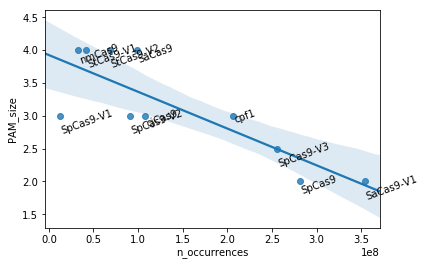

In [23]:
pam_presence_df = pd.DataFrame.from_dict(pams_in_genome, orient='index')

pam_presence_df
pam_presence_df.columns = ['n_occurrences']
pam_presence_df['Cas'] = pam_presence_df.index

pam_presence_df['PAM_size'] = pam_presence_df.apply(lambda row: pam_sizes[row['Cas']], axis=1)
# pam_presence_df.to_csv('paper_figures/pam_size_df.tsv', sep='\t', index=False)

pam_presence_df.sort_values(by='n_occurrences', ascending=False)

p = sns.regplot('n_occurrences', 'PAM_size', data=pam_presence_df, ci=95)
counter = -1
for cas in pam_presence_df.Cas.tolist():
    counter += 1
    p.annotate(cas, (pam_presence_df.n_occurrences.tolist()[counter],pam_presence_df.PAM_size.tolist()[counter]),
              rotation=20)
    
# plt.savefig('paper_figures/pams_vs_size_hg19.pdf', dpi=300)

# Supplementary Figure 3: dual cuts > single cuts WTC

Dual cuts target many more genes that single cuts in WTC. 

/pollard/home/kathleen/tools/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


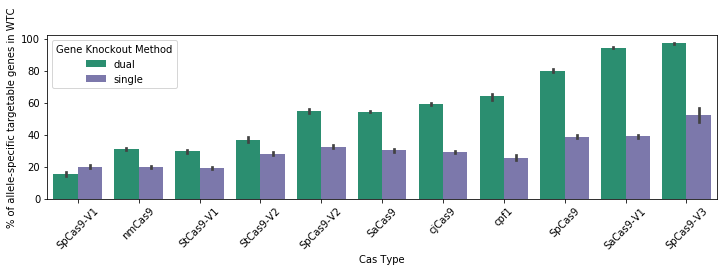

In [21]:
def n_targ_genes(chrom, cas='all'):
    df = pd.read_csv(f'../wtc_ef/single_cut_targetable_genes/chr{chrom}/chr{chrom}_single_var_targ_genes.tsv', sep='\t')
    n_targs = df[cas].sum()
    n_genes = df.shape[0]
    percent_genes = (n_targs/n_genes)*100.0
    return(percent_genes)

def n_targ_genes_v3(chrom):
    df = pd.read_csv(f'../wtc_ef/single_cut_targetable_genes/chr{chrom}/chr{chrom}_single_var_targ_genes.tsv', sep='\t')
    targs1 = df['gene'][df['SpCas9_VQR_1']].tolist()
    targs2 = df['gene'][df['SpCas9_VQR_2']].tolist()
    genes = targs1 + targs2
    n_targs = len(genes)
    n_genes = df.shape[0]
    perc_targ = (n_targs/n_genes)*100.0
    return(perc_targ)

CAS_LIST = ['all', 'SpCas9', 'SpCas9_VRER', 'SpCas9_EQR', 'SpCas9_VQR_1',
            'SpCas9_VQR_2', 'StCas9', 'StCas9_2',
            'SaCas9', 'SaCas9_KKH', 'nmCas9',
            'cjCas9', 'cpf1']

cases2 = {'Cas9':'SpCas9',
 'Cas9-V1':'SpCas9-V1',
 'Cas9-V2':'SpCas9-V2',
 'Cas9-V3':'SpCas9-V3',
 'SaCas9':'SaCas9',
 'SaCas9-V1':'SaCas9-V1',
 'StCas9-2':'StCas9-V2',
 'StCas9-V1':'StCas9-V1'}
colors = list(sns.color_palette("Dark2", n_colors=4))

cas_list = []
chromosome = []
perc_targ_vars = []

chroms = list(range(1,23))
for chrom in chroms:
    for cas in CAS_LIST:
        perc_targ = n_targ_genes(chrom, cas)
        cas_list.append(cas)
        chromosome.append(chromosome)
        perc_targ_vars.append(perc_targ)
    cas_list.append('SpCas9-V3')
    chromosome.append(chrom)
    perc_targ_vars.append(n_targ_genes_v3(chrom))

wtc_singles = pd.DataFrame({'cas':cas_list, 'chromosome':chromosome, 'perc_targ_vars':perc_targ_vars})
wtc_singles.replace(to_replace=cas_dict, inplace=True)
wtc_singles['targ_type'] = 'single'

wtc_var_plot_df = pd.read_csv('../wtc_ef/wtc_ef_plotting_data/wtc_var_plot_df.tsv', sep='\t')
# wtc_var_plot_df.head()

wtc_var_plot_df.replace(to_replace=cases2, inplace=True)
wtc_var_plot_df['perc_targ_vars'] = wtc_var_plot_df['prop_targ_vars'] * 100.0
wtc_var_plot_df['chromosome'] = wtc_var_plot_df['chromosomes']
wtc_var_plot_df = wtc_var_plot_df[['cas','chromosome','perc_targ_vars']]
wtc_var_plot_df['targ_type'] = 'dual'
# wtc_var_plot_df.head()

wtc_var_targ_plot_df = pd.concat([wtc_singles, wtc_var_plot_df]).replace(to_replace = cases2)
wtc_var_targ_plot_df.sort_values(by='perc_targ_vars', inplace=True)

fig, ax = plt.subplots(figsize=(12, 3))
p = sns.barplot(x='cas', y='perc_targ_vars', hue='targ_type', 
                order=['SpCas9-V1','nmCas9','StCas9-V1','StCas9-V2',
                       'SpCas9-V2','SaCas9','cjCas9', 'cpf1', 
                       'SpCas9','SaCas9-V1','SpCas9-V3'],palette={'single':colors[2],'dual':colors[0]}, data=wtc_var_targ_plot_df)
p.set(xlabel='Cas Type', ylabel='% of allele-specific targetable genes in WTC')
plt.setp(p.get_xticklabels(), rotation=45)
l = ax.legend()
l.set_title('Gene Knockout Method')
# fig.savefig('figures/supp_fig_3.pdf', dpi=300, bbox_inches='tight')

# Supplementary Figure 4: gene targ by pop

Gene targetability varies by population, and no population is universally more targetable at every gene.

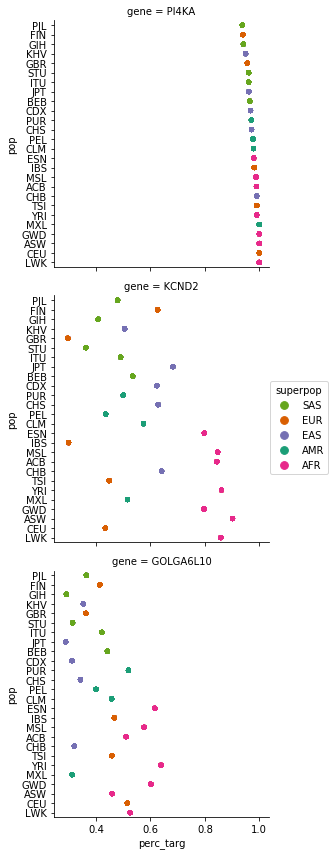

In [21]:
colors = list(sns.color_palette("Dark2", n_colors=5))

genes = {'PI4KA':'22','KCND2':'7','GOLGA6L10':'15'}
# genes2 = {'DYNC1H1':'14',''}

plot_dicts = []

for gene in genes.keys():
    chrom = genes[gene]
    rp1 = pd.read_hdf(f'/pollard/data/1kg/ef/gene_targ_outputs/chr{chrom}/chr{chrom}_out.hdf5',f'{gene}')

    rp1_pops = rp1.merge(sample_legend, how='left')

    plot_dict_rp1 = {}

    for pop in sample_legend['pop'].tolist():
        plot_dict_rp1[pop] = rp1_pops.query('pop == @pop and targ_all').shape[0]/sample_legend.query('pop == @pop').shape[0]

    plot_df_rp1 = pd.DataFrame.from_dict(plot_dict_rp1, orient='index')
    plot_df_rp1['pop'] = plot_df_rp1.index
    plot_df_rp1.columns=['perc_targ','pop']
    plot_df_rp1 = plot_df_rp1.merge(sample_legend)
    plot_df_rp1 = plot_df_rp1.sort_values(by='perc_targ')
    plot_df_rp1['gene'] = gene
    plot_df_rp1['type'] = 'large'
    plot_dicts.append(plot_df_rp1)
    
# for gene in genes2.keys():
#     chrom = genes2[gene]
#     rp1 = pd.read_hdf(f'/pollard/data/1kg/ef/gene_targ_outputs/chr{chrom}/chr{chrom}_out.hdf5',f'{gene}')

#     rp1_pops = rp1.merge(sample_legend, how='left')

#     plot_dict_rp1 = {}

#     for pop in sample_legend['pop'].tolist():
#         plot_dict_rp1[pop] = rp1_pops.query('pop == @pop and targ_all').shape[0]/sample_legend.query('pop == @pop').shape[0]

#     plot_df_rp1 = pd.DataFrame.from_dict(plot_dict_rp1, orient='index')
#     plot_df_rp1['pop'] = plot_df_rp1.index
#     plot_df_rp1.columns=['perc_targ','pop']
#     plot_df_rp1 = plot_df_rp1.merge(sample_legend)
#     plot_df_rp1 = plot_df_rp1.sort_values(by='perc_targ')
#     plot_df_rp1['gene'] = gene
#     plot_df_rp1['type'] = 'large'
#     plot_dicts.append(plot_df_rp1)
    
plot_df = pd.concat(plot_dicts)

# p = sns.stripplot(x='perc_targ', y='pop', hue='superpop', row='gene',
#                   palette = {'AMR':colors[0], 'EUR':colors[1],
#                             'EAS':colors[2],'AFR':colors[3],
#                             'SAS':colors[4]}, data=plot_df)

p = sns.factorplot(x='perc_targ', y='pop', hue='superpop',row='gene', 
#                    col='type',
                   data=plot_df, kind='strip',
                  palette = {'AMR':colors[0], 'EUR':colors[1],
                            'EAS':colors[2],'AFR':colors[3],
                            'SAS':colors[4]})
# leg = p.axes.get_legend()
# leg.set_title('Super Population')
# p.set(xlabel=f'% population targetable for {gene}', ylabel='Population')
p.savefig(f'figures/wtc_big_genes_targ_pops.pdf', dpi=300)

# Supplementary Figure 6: Different #s of sites targetable inds

Even targetable individuals have varying numbers of allele-specific CRISPR sites.

In [4]:
transcript = get_canonical('RHO', gene_annots)

rho_start = gene_annots.query('name == @transcript').txStart.item()
rho_stop = gene_annots.query('name == @transcript').txEnd.item()

rho_5kb_start = rho_start - 5000
rho_5kb_stop = rho_stop + 5000

In [5]:
rho_vars = pd.read_hdf('/pollard/data/1kg/excisionFinderData/targ_dfs/chr3_targ.hdf5','all', where='pos <= rho_stop and pos >= rho_start')
rho_5kb_vars = pd.read_hdf('/pollard/data/1kg/excisionFinderData/targ_dfs/chr3_targ.hdf5','all', where='pos <= rho_5kb_stop and pos >= rho_5kb_start')

/pollard/home/kathleen/tools/anaconda3/lib/python3.6/site-packages/tables/leaf.py:396: PerformanceWarning: The Leaf ``/all/_i_table/alt/sorted`` is exceeding the maximum recommended rowsize (104857600 bytes);
be ready to see PyTables asking for *lots* of memory and possibly slow
I/O.  You may want to reduce the rowsize by trimming the value of
dimensions that are orthogonal (and preferably close) to the *main*
dimension of this leave.  Alternatively, in case you have specified a
very small/large chunksize, you may want to increase/decrease it.
  PerformanceWarning)


In [9]:
rho_gens = pd.read_hdf('/pollard/data/1kg/excisionFinderData/gene_targ_outputs/chr3/hap_targ_ind_3.hdf5','RHO')
rho_5kb_gens = pd.read_hdf('plotting_data/RHO_5kb/hap_targ_ind_3.hdf5','RHO')

In [24]:
rho_gens.columns

Index(['pos', 'sample', 'hap1_SpCas9', 'hap2_SpCas9', 'hap1_SpCas9_VRER',
       'hap2_SpCas9_VRER', 'hap1_SpCas9_EQR', 'hap2_SpCas9_EQR',
       'hap1_SpCas9_VQR_1', 'hap2_SpCas9_VQR_1', 'hap1_SpCas9_VQR_2',
       'hap2_SpCas9_VQR_2', 'hap1_StCas9', 'hap2_StCas9', 'hap1_StCas9_2',
       'hap2_StCas9_2', 'hap1_SaCas9', 'hap2_SaCas9', 'hap1_SaCas9_KKH',
       'hap2_SaCas9_KKH', 'hap1_nmCas9', 'hap2_nmCas9', 'hap1_cjCas9',
       'hap2_cjCas9', 'hap1_cpf1', 'hap2_cpf1'],
      dtype='object')

In [53]:
CAS_LIST = ['SpCas9', 'SpCas9_VRER', 'SpCas9_EQR', 'SpCas9_VQR_1',
            'SpCas9_VQR_2', 'StCas9', 'StCas9_2',
            'SaCas9', 'SaCas9_KKH', 'nmCas9',
            'cjCas9', 'cpf1']
samp_dict_rho = {}
samp_dict_rho_5kb = {}

for cas in CAS_LIST:
    samp_dict_rho[cas] = {}
    if cas == 'SpCas9_VQR_1':
        for sample in all_samples:
            if rho_gens.query('sample == @sample').empty:
                samp_dict_rho[cas][sample] = 0
            else:
                samp_dict_rho[cas][sample] = rho_gens.query(f'(sample == @sample and hap1_SpCas9_VQR_1) \
                                                   or (sample == @sample and hap2_SpCas9_VQR_1) \
                                                   or (sample == @sample and hap1_SpCas9_VQR_2) \
                                                   or (sample == @sample and hap2_SpCas9_VQR_2)').shape[0]
    elif cas == 'SpCas9_VQR_2':
        continue
    else:
        for sample in all_samples:
            if rho_gens.query('sample == @sample').empty:
                samp_dict_rho[cas][sample] = 0
            else:
                samp_dict_rho[cas][sample] = rho_gens.query(f'(sample == @sample and hap1_{cas}) \
                or (sample == @sample and hap2_{cas})').shape[0]
                
for cas in CAS_LIST:
    samp_dict_rho_5kb[cas] = {}
    if cas == 'SpCas9_VQR_1':
        for sample in all_samples:
            if rho_5kb_gens.query('sample == @sample').empty:
                samp_dict_rho_5kb[cas][sample] = 0
            else:
                samp_dict_rho_5kb[cas][sample] = rho_5kb_gens.query(f'(sample == @sample and hap1_SpCas9_VQR_1) \
                                                   or (sample == @sample and hap2_SpCas9_VQR_1) \
                                                   or (sample == @sample and hap1_SpCas9_VQR_2) \
                                                   or (sample == @sample and hap2_SpCas9_VQR_2)').shape[0]
    elif cas == 'SpCas9_VQR_2':
        continue
    else:
        for sample in all_samples:
            if rho_5kb_gens.query('sample == @sample').empty:
                samp_dict_rho_5kb[cas][sample] = 0
            else:
                samp_dict_rho_5kb[cas][sample] = rho_5kb_gens.query(f'(sample == @sample and hap1_{cas}) \
                or (sample == @sample and hap2_{cas})').shape[0]

In [54]:
df_list = []

for cas in samp_dict_rho.keys():
    df = pd.DataFrame.from_dict(samp_dict_rho[cas], orient='index')
#     df.columns = ['n_targ_sites']
    df['cas'] = cas
    df['type'] = 'gene'
#     df['sample'] = df.index
    df_list.append(df)
    df2 = pd.DataFrame.from_dict(samp_dict_rho_5kb[cas], orient='index')
#     df.columns = ['n_targ_sites']
    df2['cas'] = cas 
    df2['type'] = '5kb'
#     df['sample'] = df.index
    df_list.append(df2)

In [74]:
plot_df = pd.concat(df_list)
plot_df.columns = ['n_sites','cas','type']
plot_df = plot_df.sort_values(by='type', ascending=False)
plot_df.head()

,n_sites,cas,type
HG01879,8.0,SpCas9,gene
NA19089,0.0,StCas9,gene
HG02601,2.0,StCas9,gene
HG02600,0.0,StCas9,gene
HG02597,3.0,StCas9,gene


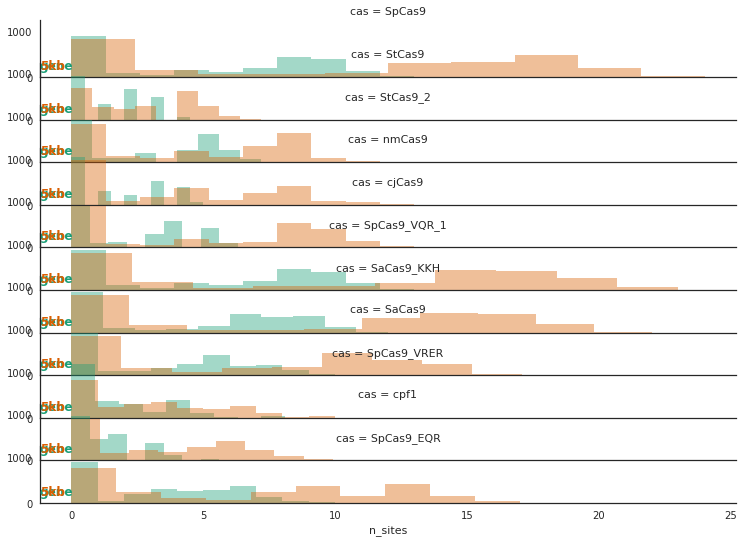

In [87]:
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
g = sns.FacetGrid(plot_df, row='cas', hue='type', aspect=15, size=0.7, palette='Dark2')
g.map(plt.hist, 'n_sites', alpha=0.4)
# g.map(sns.kdeplot, "n_sites", clip_on=False, color="w", lw=2, bw=.2)
# g.map(plt.axhline, y=0, lw=2, clip_on=False)
# def label(x, color, label):
#     ax = plt.gca()
#     ax.text(0, .2, label, fontweight="bold", color=color, 
#             ha="left", va="center", transform=ax.transAxes)

g.map(label, "n_sites")
g.fig.subplots_adjust(hspace=-.25)

# Supplementary Table 3: gene groups WTC

Summary of gene groups in WTC. 

In [ ]:
allwtrans = pd.read_csv('../wtc_ef/wtc_ef_plotting_data/wtc_allwtrans.tsv', sep='\t')
scipy.stats.iqr(allwtrans.query('gene_group == "targetable"')['n_exons'].tolist())

scipy.stats.iqr(allwtrans.query('gene_group == "targetable"')['size'].tolist())

scipy.stats.iqr(allwtrans.query('gene_group == "not targetable"')['n_exons'].tolist())

scipy.stats.iqr(allwtrans.query('gene_group == "not targetable"')['size'].tolist())

scipy.stats.iqr(allwtrans.query('gene_group == "not enough hets"')['n_exons'].tolist())

scipy.stats.iqr(allwtrans.query('gene_group == "not enough hets"')['size'].tolist())

allwtrans.query('gene_group != "no coding exons"').groupby(['gene_group']).median()